# Graph embedding using [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

from sklearn.decomposition import PCA

from graph_embedding_continuity import *

In [2]:
N = 50
# Barabasi-Albert parameter
m = 5
# number of edge(s) to remove
k_remove = 1

N_TRAIN = 50
EMBEDDING_SIZE = 4
WALK_LENGTH = 10
WINDOW_SIZE = 2
N_NEG = 2
HIDDEN_SIZE = 16

USE_CUDA = False

## Embedding under removal of an edge (while keeping the graph connected)

Epoch : 1/50: 100%|███████████████████████████████████| 50.0/50.0 [00:01<00:00, 35.3it/s, loss=51.2]
Epoch : 10/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 41.2it/s, loss=50.6]
Epoch : 20/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.4it/s, loss=47.8]
Epoch : 30/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.0it/s, loss=47.2]
Epoch : 40/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.4it/s, loss=45.8]
Epoch : 50/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 42.9it/s, loss=46.3]
Epoch : 1/50: 100%|███████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.4it/s, loss=51.3]
Epoch : 10/50: 100%|████████████████████████████████████| 50.0/50.0 [00:01<00:00, 42.9it/s, loss=50]
Epoch : 20/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.2it/s, loss=47.4]
Epoch : 30/50: 100%|██████████████████████████████████| 50.0/50.0 [00:01<00:00, 43.3it/s, l

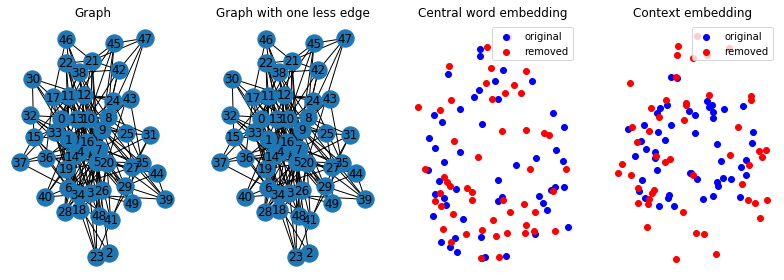

In [3]:
# generate a random graph
G = nx.barabasi_albert_graph(N, m)

# add some random weights on each edge    
for u, v, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph with one edge randomly removed
G_removed = remove_random_edges(G, k=k_remove, in_place=False)

emb_word, emb_context = deepwalk_embedding(G,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = deepwalk_embedding(G_removed,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding')
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding')
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

## Embedding under removal of an edge that disconnects the graph

Epoch : 50/50: 100%|████████████████████████████████████| 100/100 [00:02<00:00, 40.2it/s, loss=29.6]
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


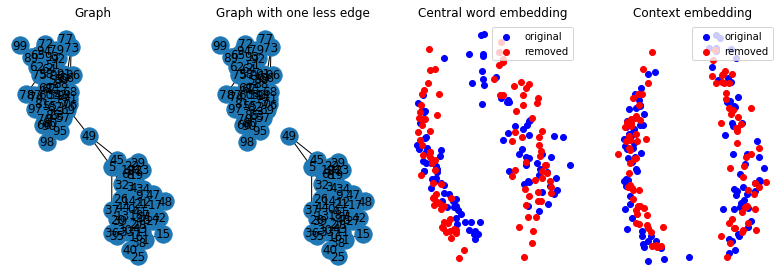

In [4]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G = nx.union(G1, G2)

G.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph by removing the bridge edge, resulting in a disconnected graph
G_removed = deepcopy(G)
G_removed.remove_edge(N-1, N)

emb_word, emb_context = deepwalk_embedding(G,
                                           k=EMBEDDING_SIZE,
                                           n_train=N_TRAIN,
                                           walk_length=WALK_LENGTH,
                                           window_size=WINDOW_SIZE,
                                           n_neg=N_NEG,
                                           hidden_size = HIDDEN_SIZE,
                                           use_cuda=USE_CUDA,
                                          )
emb_removed_word, emb_removed_context = deepwalk_embedding(G_removed,
                                                           k=EMBEDDING_SIZE,
                                                           n_train=N_TRAIN,
                                                           walk_length=WALK_LENGTH,
                                                           window_size=WINDOW_SIZE,
                                                           n_neg=N_NEG,
                                                           hidden_size = HIDDEN_SIZE,
                                                           use_cuda=USE_CUDA,
                                                          )

# extract 2 principal components to plot
pca = PCA(n_components=2)
emb_word = pca.fit_transform(emb_word.cpu())
emb_context = pca.fit_transform(emb_context.cpu())
emb_removed_word = pca.fit_transform(emb_removed_word.cpu())
emb_removed_context = pca.fit_transform(emb_removed_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(G, pos = pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_removed, pos = pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[2]
ax.scatter(emb_word[:, 0], emb_word[:, 1], label='original', color='b')
ax.scatter(emb_removed_word[:, 0], emb_removed_word[:, 1], label='removed', color='r')
ax.set_title('Central word embedding')
ax.legend(loc='upper right')
ax.axis('off')


ax = axes[3]
ax.scatter(emb_context[:, 0], emb_context[:, 1], label='original', color='b')
ax.scatter(emb_removed_context[:, 0], emb_removed_context[:, 1], label='removed', color='r')
ax.set_title('Context embedding')
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()